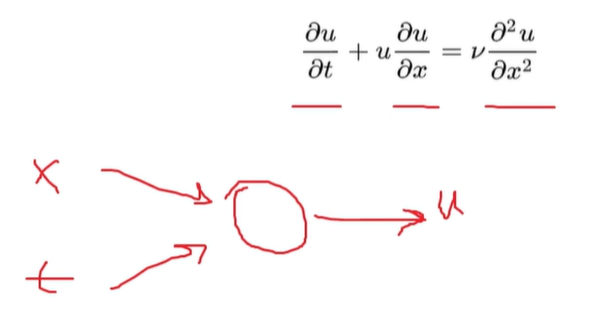

The Burgers equation - we are looking to get the space (x) and the time (t) and give us the u value

In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn # to show the progress bar in case you would like to see it

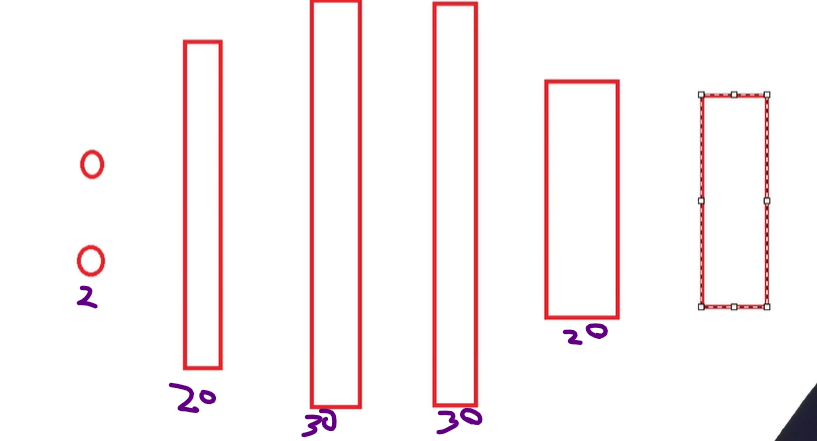

In [2]:
class NN(nn.Module):
  def __init__(self):
    super(NN, self).__init__()
    self.net = torch.nn.Sequential(
        nn.Linear(2,20),
        nn.Tanh(),
        nn.Linear(20,30),
        nn.Tanh(),
        nn.Linear(30,30),
        nn.Tanh(),
        nn.Linear(30,20),
        nn.Tanh(),
        nn.Linear(20,20),
        nn.Tanh(),
        nn.Linear(20,1),
    )
  def forward(self, x):
    out = self.net(x)
    return out

In [3]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        # declare the model
        self.model = NN().to(device)

        # comp. domain
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2, ic])

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic  = -torch.sin(math.pi * ic[:,0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred,self.y_train)

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx , (0.01/math.pi) * du_dxx)

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

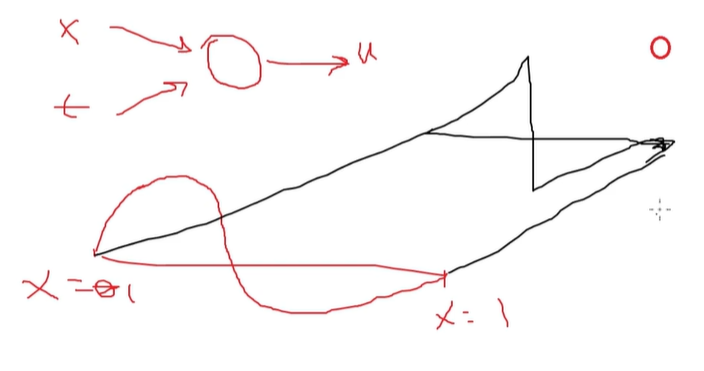

In [4]:
# x_test = torch.arange(-1, 1 + 0.1, 0.1)
# print(x_test)
# t_test = torch.arange(0, 1 + 0.1, 0.1)
# print(t_test)

# X = torch.stack(torch.meshgrid(x_test, t_test)).reshape(2, -1).T
# print(X)

So now we got the x and t that we can feed to the network.

In [5]:
# training
net = Net()
net.train()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


100 0.11316490173339844
200 0.09003682434558868
300 0.07715378701686859
400 0.06578619033098221
500 0.047773875296115875
600 0.028469299897551537
700 0.02469174563884735
800 0.02449241280555725
900 0.01813611015677452
1000 0.01623448356986046
1100 0.009728499688208103
1200 0.005147277843207121
1300 0.0025919675827026367
1400 0.00172860873863101
1500 0.001128806034103036
1600 0.0007552700117230415
1700 0.0005361892399378121
1800 0.000409006723202765
1900 0.0003056586720049381
2000 0.00021910161012783647
2100 0.0001703307352727279
2200 0.0001380747271468863
2300 0.00011407519923523068
2400 9.502220927970484e-05
2500 8.112519572023302e-05
2600 6.914982805028558e-05
2700 6.34662137599662e-05
2800 5.718523607356474e-05
2900 5.023584526497871e-05
3000 4.531104059424251e-05
3100 4.023668589070439e-05
3200 3.708977237693034e-05
3300 3.587153696571477e-05
3400 3.5182969440938905e-05
3500 3.377206303412095e-05
3600 3.2841733627719805e-05
3700 3.162467692163773e-05
3800 3.0835864890832454e-05
390

In [6]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(-1,1,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

In [7]:
X

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9900],
        [-1.0000, -0.9800],
        ...,
        [ 0.9900,  0.9700],
        [ 0.9900,  0.9800],
        [ 0.9900,  0.9900]], device='cuda:0')

In [8]:
X.shape

torch.Size([40000, 2])

In [9]:
model = net.model
model.eval()
with torch.no_grad():
  y_pred = model(X)
  y_pred = y_pred.reshape(len(x), len(t)).cpu().numpy()

In [10]:
y_pred.shape

(200, 200)

In [11]:
y_pred

array([[-1.4979765 , -1.4930426 , -1.4877177 , ..., -0.00198058,
        -0.00199984, -0.00201804],
       [-1.4338247 , -1.4281532 , -1.4220772 , ...,  0.0057768 ,
         0.00570152,  0.00562822],
       [-1.3692936 , -1.3628563 , -1.3560032 , ...,  0.01353067,
         0.01339914,  0.01327087],
       ...,
       [-0.4385604 , -0.4339582 , -0.42934135, ..., -0.02486821,
        -0.02468254, -0.02450167],
       [-0.4185981 , -0.41366294, -0.4087068 , ..., -0.01696326,
        -0.01684167, -0.01672437],
       [-0.39792076, -0.3926424 , -0.38733724, ..., -0.00905233,
        -0.00899585, -0.008942  ]], dtype=float32)

In [12]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred, cmap='jet')

<Axes: >

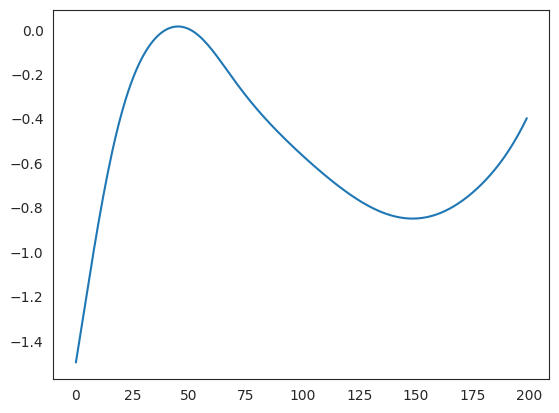

In [13]:
plt.plot(y_pred[:,0])

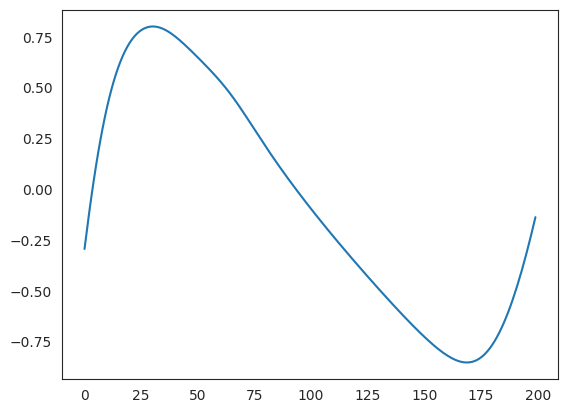

In [14]:
plt.plot(y_pred[:,50])

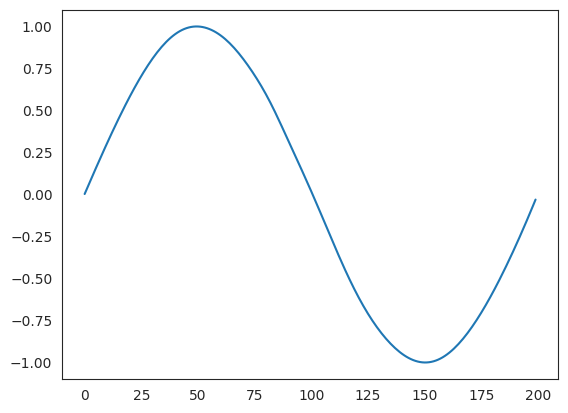

In [15]:
plt.plot(y_pred[:,100])